In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow_addons.optimizers import AdamW, Yogi  # You need TensorFlow Addons for AdamW and Yogi
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [4]:
class TitanicDatasetPreprocessor:
    def __init__(self, train_path, test_path):
        self.train_path = train_path
        self.test_path = test_path
        self.traindf = None
        self.testdf = None
        self.target = None
        self.train = None
        self.test = None
        self.X_train = None
        self.X_test = None
        self.X_val = None  # Validation data
        self.y_train = None
        self.y_test = None
        self.y_val = None  # Validation target
        self.Xc = None
        self.yc = None
    def load_data(self):
        self.traindf = pd.read_csv(self.train_path)
        self.testdf = pd.read_csv(self.test_path)

    def preprocess_data(self):
        # Concatenate train and test dataframes
        df = pd.concat([self.traindf, self.testdf], axis=0, sort=False)

        # Extract Title from Name
        df['Title'] = df.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
        df['Title'] = df['Title'].replace(['Ms', 'Mlle'], 'Miss')
        df['Title'] = df['Title'].replace('Mme', 'Mrs')

        # Extract LastName
        df['LastName'] = df.Name.str.split(',').str[0]

        # Identify women and boys
        df['IsWomanOrBoy'] = ((df['Title'] == 'Master') | (df['Sex'] == 'female'))

        # Count women and boys in the family
        df['WomanOrBoyCount'] = df.groupby('LastName')['IsWomanOrBoy'].transform('sum')
        # Subtract one from WomanOrBoyCount if individual is a woman or boy
        df['WomanOrBoyCount'] = df['WomanOrBoyCount'] - df['IsWomanOrBoy']

        # Count survived women and boys in the family
        df['FamilySurvivedCount'] = df.groupby('LastName')['Survived'].transform('sum')

        # Subtract survived count for current individual if woman or boy
        df['FamilySurvivedCount'] = df['FamilySurvivedCount'] - df['IsWomanOrBoy'] * df['Survived'].fillna(0)

        # Calculate survival rate of women and boys in the family
        df['WomanOrBoySurvived'] = df['FamilySurvivedCount'] / df['WomanOrBoyCount'].replace(0, np.nan)

        # Handle missing values
        df['WomanOrBoyCount'] = df['WomanOrBoyCount'].fillna(0)
        df['WomanOrBoySurvived'] = df['WomanOrBoySurvived'].fillna(0)

        # Impute missing values
        df['Embarked'] = df['Embarked'].fillna('S')
        df['Deck'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
        df.loc[df['Deck'] == 'T', 'Deck'] = 'A'
        med_fare = df.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
        df['Fare'] = df['Fare'].fillna(med_fare)

        # Reset index again
        df.reset_index(drop=True, inplace=True)

        # Calculate median age by group
        age_group_medians = df.groupby(['Sex', 'Pclass', 'Title'])['Age'].median()

        # Fill missing values using median age by group
        df['Age'] = df.apply(
            lambda row: age_group_medians[row['Sex'], row['Pclass'], row['Title']] if np.isnan(row['Age']) else row['Age'],
            axis=1
        )

        # Calculate Family_Size
        df['Family_Size'] = df['SibSp'] + df['Parch'] + 1

        # Drop unnecessary columns
        cols_to_drop = ['Name', 'Ticket', 'Cabin']
        df = df.drop(cols_to_drop, axis=1)

        # Fill missing values
        df['Alone'] = (df['WomanOrBoyCount'] == 0).astype(int)

        # Fill remaining missing values
        df['WomanOrBoySurvived'] = df['WomanOrBoySurvived'].fillna(0)
        df['WomanOrBoyCount'] = df['WomanOrBoyCount'].fillna(0)
        df['FamilySurvivedCount'] = df['FamilySurvivedCount'].fillna(0)
        df['Alone'] = df['Alone'].fillna(0)

        self.target = df.Survived.loc[self.traindf.index]
        df = df.drop(['Survived'], axis=1)
        self.train, self.test = df.loc[self.traindf.index], df.loc[self.testdf.index]
        self.Xc=  self.train
        self.yc = self.target
    def encode_categorical_features(self):
        numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        categorical_columns = []
        features = self.train.columns.values.tolist()
        for col in features:
            if self.train[col].dtype in numerics:
                continue
            categorical_columns.append(col)

        for col in categorical_columns:
            if col in self.train.columns:
                le = LabelEncoder()
                le.fit(list(self.train[col].astype(str).values) + list(self.test[col].astype(str).values))
                self.train[col] = le.transform(list(self.train[col].astype(str).values))
                self.test[col] = le.transform(list(self.test[col].astype(str).values))

    def split_train_test(self, test_size=0.3, random_state=100):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.train, self.target,
                                                                            test_size=test_size,
                                                                            random_state=random_state)
        # Further split training data into training and validation sets
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train,
                                                                            test_size=0.2,
                                                                            random_state=random_state)
        return self.X_train, self.X_val, self.X_test, self.y_train, self.y_val, self.y_test 


In [21]:
# class NeuralNetworkModel:
#     def __init__(self):
#         self.model = None
    
#     def build_ann(self, input_shape, optimizer='adam'):
#         self.model = Sequential()
#         self.model.add(Dense(units=32, kernel_initializer='glorot_uniform', activation='relu', input_shape=(input_shape,)))
#         self.model.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
#         self.model.add(Dropout(rate=0.5))
#         self.model.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
#         self.model.add(Dropout(rate=0.5))
#         self.model.add(Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))
#         self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=16):
#         history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0)
#         return history
    
#     def evaluate(self, X_test, y_test):
#         y_pred_prob = self.model.predict(X_test)
#         y_pred = (y_pred_prob > 0.5).astype(int)
#         accuracy = accuracy_score(y_test, y_pred)
#         precision = precision_score(y_test, y_pred)
#         recall = recall_score(y_test, y_pred)
#         f1 = f1_score(y_test, y_pred)
#         return accuracy, precision, recall, f1

In [62]:
# Define the NeuralNetworkModel class
class NeuralNetworkModel:
    def __init__(self):
        self.model = None

    def build_ann(self, input_shape, optimizer):
        """Build a FFNN model compatible with the data."""
        self.model = Sequential()
        self.model.add(Dense(units=32, kernel_initializer='glorot_uniform', activation='relu', input_shape=(input_shape,)))
        # self.model.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
        # self.model.add(Dropout(rate=0.5))
        # self.model.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
        # self.model.add(Dropout(rate=0.5))
        self.model.add(Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))
        self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        
    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
        return self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

    def evaluate(self, X_test, y_test):
        y_pred_prob = self.model.predict(X_test)
        y_pred = np.round(y_pred_prob).astype(int).flatten()
        if isinstance(y_test, pd.Series):
           y_test = y_test.values
        y_true = y_test.flatten()
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        return accuracy, precision, recall, f1

In [63]:
# Example usage
# train_path = "train.csv"
# test_path = "test.csv"
preprocessor = TitanicDatasetPreprocessor('Titanic-data/train (1).csv', 'Titanic-data/test.csv')
preprocessor.load_data()
preprocessor.preprocess_data()
preprocessor.encode_categorical_features()
# X_train, X_val, X_test, y_train, y_val, y_test , Xc, yc = preprocessor.split_train_test()
X_train, X_val, X_test, y_train, y_val, y_test = preprocessor.split_train_test()

In [64]:
# # Define reduction percentages
# reduction_percentage = 0.7

# # Reduce the size of the datasets
# X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=reduction_percentage, random_state=42)
# X_val, _, y_val, _ = train_test_split(X_val, y_val, test_size=reduction_percentage, random_state=42)
# X_test, _, y_test, _ = train_test_split(X_test, y_test, test_size=reduction_percentage, random_state=42)

In [77]:
X_train.shape , X_val.shape, X_test.shape,  y_train.shape

((498, 17), (125, 17), (268, 17), (498,))

In [70]:
# List of optimizers to test for NN
optimizers = {
    'SGD': SGD(),
    'SGD_momentum': SGD(momentum=0.9),
    'Nesterov': SGD(momentum=0.9, nesterov=True),
    'RMSprop': tf.keras.optimizers.RMSprop(),
    'Adagrad': tf.keras.optimizers.Adagrad(),
    'Adadelta': tf.keras.optimizers.Adadelta(),
    'Adam': Adam(),
    'AMSGrad': Adam(amsgrad=True),
    'AdamW': AdamW(weight_decay=1e-4),
    'Yogi': Yogi(),
    'Nadam': tf.keras.optimizers.Nadam(),
    'Adamax': tf.keras.optimizers.Adamax()
}

results = {}

# neural_network_model = NeuralNetworkModel()

for name, optimizer in optimizers.items():
    print(f"Training model with {name} optimizer...")
    neural_network_model = NeuralNetworkModel()
    neural_network_model.build_ann(X_train.shape[1], optimizer=optimizer)
    start_time = time.time()
    history = neural_network_model.train(X_train, y_train, X_val, y_val, epochs=50, batch_size=32)
    end_time = time.time()
    test_accuracy, precision, recall, f1 = neural_network_model.evaluate(X_test, y_test)
    training_time = end_time - start_time
    convergence_speed = len(history.history['loss'])
    results[name] = {
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'convergence_speed': convergence_speed,
        'training_time': training_time,
        'history': history
    }

from tensorflow.keras.initializers import RandomNormal


# By default, Keras uses the Glorot Uniform initializer for weights and zeros for biases

self.model.add(Dense(32, input_dim=input_dim, activation='relu', 
                     kernel_initializer=RandomNormal(mean=0.0, stddev=0.05), 
                     bias_initializer='zeros'))


Training model with SGD optimizer...
Epoch 1/50
16/16 [==============================] - 1s 22ms/step - loss: 45.6495 - accuracy: 0.6145 - val_loss: 0.6878 - val_accuracy: 0.6480 - lr: 0.0100
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 0.7376 - accuracy: 0.6345 - val_loss: 0.6826 - val_accuracy: 0.6640 - lr: 0.0100
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 0.7028 - accuracy: 0.6466 - val_loss: 0.7046 - val_accuracy: 0.6160 - lr: 0.0100
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 0.6882 - accuracy: 0.6446 - val_loss: 0.6987 - val_accuracy: 0.6400 - lr: 0.0100
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 0.6753 - accuracy: 0.6486 - val_loss: 0.7227 - val_accuracy: 0.6240 - lr: 0.0100
Epoch 6/50
16/16 [==============================] - 0s 11ms/step - loss: 0.6781 - accuracy: 0.6466 - val_loss: 0.6943 - val_accuracy: 0.6400 - lr: 0.0050
Epoch 7/50
16/16 [====================

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


16/16 [==============================] - 1s 21ms/step - loss: 26.2967 - accuracy: 0.6145 - val_loss: 0.7086 - val_accuracy: 0.6560 - lr: 0.0100
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 0.6744 - accuracy: 0.6185 - val_loss: 0.6630 - val_accuracy: 0.6560 - lr: 0.0100
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 0.6674 - accuracy: 0.6185 - val_loss: 0.6549 - val_accuracy: 0.6560 - lr: 0.0100
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 0.6644 - accuracy: 0.6185 - val_loss: 0.6516 - val_accuracy: 0.6560 - lr: 0.0100
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.6630 - accuracy: 0.6185 - val_loss: 0.6543 - val_accuracy: 0.6560 - lr: 0.0100
Epoch 6/50
16/16 [==============================] - 0s 11ms/step - loss: 0.6627 - accuracy: 0.6185 - val_loss: 0.6502 - val_accuracy: 0.6560 - lr: 0.0100
Epoch 7/50
16/16 [==============================] - 0s 11ms/step - loss: 0.6626 - accu

In [71]:
# Print results
print("\nResults:")
for name, result in results.items():
    print(f"{name}: Test Accuracy - {result['test_accuracy']:.4f}, "
          f"Precision - {result['precision']:.4f}, "
          f"Recall - {result['recall']:.4f}, "
          f"F1-score - {result['f1_score']:.4f}, "
          f"Convergence Speed - {result['convergence_speed']} epochs, "
          f"Training Time - {result['training_time']:.2f} seconds")


Results:
SGD: Test Accuracy - 0.6082, Precision - 0.6434, Recall - 0.6082, F1-score - 0.4917, Convergence Speed - 12 epochs, Training Time - 2.73 seconds
SGD_momentum: Test Accuracy - 0.5933, Precision - 0.3520, Recall - 0.5933, F1-score - 0.4418, Convergence Speed - 25 epochs, Training Time - 4.97 seconds
Nesterov: Test Accuracy - 0.5896, Precision - 0.3511, Recall - 0.5896, F1-score - 0.4401, Convergence Speed - 18 epochs, Training Time - 3.67 seconds
RMSprop: Test Accuracy - 0.7425, Precision - 0.7674, Recall - 0.7425, F1-score - 0.7210, Convergence Speed - 50 epochs, Training Time - 10.87 seconds
Adagrad: Test Accuracy - 0.4104, Precision - 0.4183, Recall - 0.4104, F1-score - 0.4138, Convergence Speed - 50 epochs, Training Time - 9.75 seconds
Adadelta: Test Accuracy - 0.4440, Precision - 0.5805, Recall - 0.4440, F1-score - 0.3495, Convergence Speed - 50 epochs, Training Time - 10.69 seconds
Adam: Test Accuracy - 0.7761, Precision - 0.7750, Recall - 0.7761, F1-score - 0.7726, Conve

In [72]:
# Data extraction for the summary
data_info = {
    'Data Name': ["Titanic"] * len(optimizers),
    'Data Size': [X_train.shape[0]] * len(optimizers),
    'Number of Features': [X_train.shape[1]] * len(optimizers),
    'Target Feature Type': [y_train.dtype] * len(optimizers),
    'Neural Network Architecture': ["FNN"] * len(optimizers),
    'Optimization Method': list(optimizers.keys())
}

# Extract results for each optimization method
results_info = {
    'Optimization Method': [],
    'Test Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-score': [],
    'Convergence Speed': [],
    'Training Time': [],
    'Training Loss': [],
    'Validation Loss': []
}

# Add the evaluation results for each optimizer
for optimizer, result in results.items():
    results_info['Optimization Method'].append(optimizer)
    results_info['Test Accuracy'].append(result['test_accuracy'])
    results_info['Precision'].append(result['precision'])
    results_info['Recall'].append(result['recall'])
    results_info['F1-score'].append(result['f1_score'])
    results_info['Convergence Speed'].append(result['convergence_speed'])
    results_info['Training Time'].append(result['training_time'])
    results_info['Training Loss'].append(result['history'].history['loss'][0])
    results_info['Validation Loss'].append(result['history'].history['val_loss'][0])

# Create DataFrames and merge them for final results
data_df = pd.DataFrame(data_info)
results_df = pd.DataFrame(results_info)
final_df = pd.merge(data_df, results_df, on='Optimization Method')

# Show the final merged data
final_df.head(12)

,Data Name,Data Size,Number of Features,Target Feature Type,Neural Network Architecture,Optimization Method,Test Accuracy,Precision,Recall,F1-score,Convergence Speed,Training Time,Training Loss,Validation Loss
0,Titanic,498,17,float64,FNN,SGD,0.608209,0.643431,0.608209,0.491745,12,2.733354,45.649517,0.687826
1,Titanic,498,17,float64,FNN,SGD_momentum,0.593284,0.351985,0.593284,0.441836,25,4.968577,87.557945,0.676544
2,Titanic,498,17,float64,FNN,Nesterov,0.589552,0.351082,0.589552,0.440088,18,3.668618,26.296652,0.708633
3,Titanic,498,17,float64,FNN,RMSprop,0.742537,0.767379,0.742537,0.721016,50,10.870435,39.122200,16.907839
4,Titanic,498,17,float64,FNN,Adagrad,0.410448,0.418255,0.410448,0.413806,50,9.746452,46.034195,43.562416
5,Titanic,498,17,float64,FNN,Adadelta,0.444030,0.580480,0.444030,0.349514,50,10.689550,27.391560,24.226873
6,Titanic,498,17,float64,FNN,Adam,0.776119,0.774960,0.776119,0.772615,50,10.034266,8.233132,7.320109
7,Titanic,498,17,float64,FNN,AMSGrad,0.768657,0.767598,0.768657,0.764443,50,10.843652,39.942696,15.634178
8,Titanic,498,17,float64,FNN,AdamW,0.727612,0.737216,0.727612,0.710370,50,10.505026,49.678787,29.178774
9,Titanic,498,17,float64,FNN,Yogi,0.772388,0.775334,0.772388,0.765207,29,8.327248,9.415127,2.605602


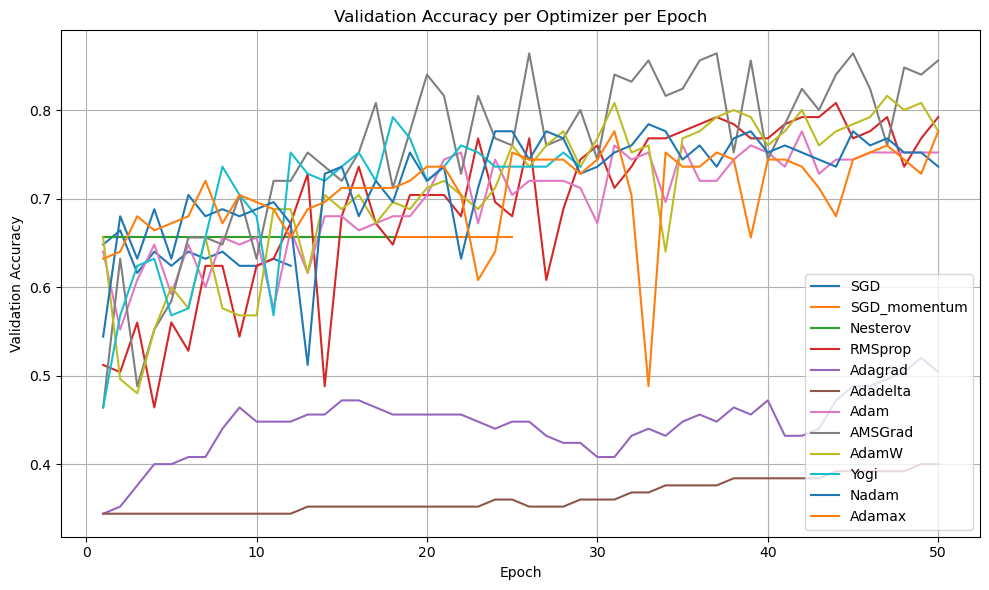

In [75]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot Test Accuracy per Optimizer per Epoch
plt.figure(figsize=(10, 6))

# Loop through results to access each optimizer's training history
for optimizer_name, result in results.items():
    # Retrieve the validation accuracy history for this optimizer
    if 'val_accuracy' in result['history'].history:
        val_acc_history = result['history'].history['val_accuracy']
    else:
        # Sometimes the key might be 'val_acc', depending on TensorFlow version
        val_acc_history = result['history'].history.get('val_acc', [])

    # Plot the validation accuracy history
    plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label=optimizer_name)

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy per Optimizer per Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


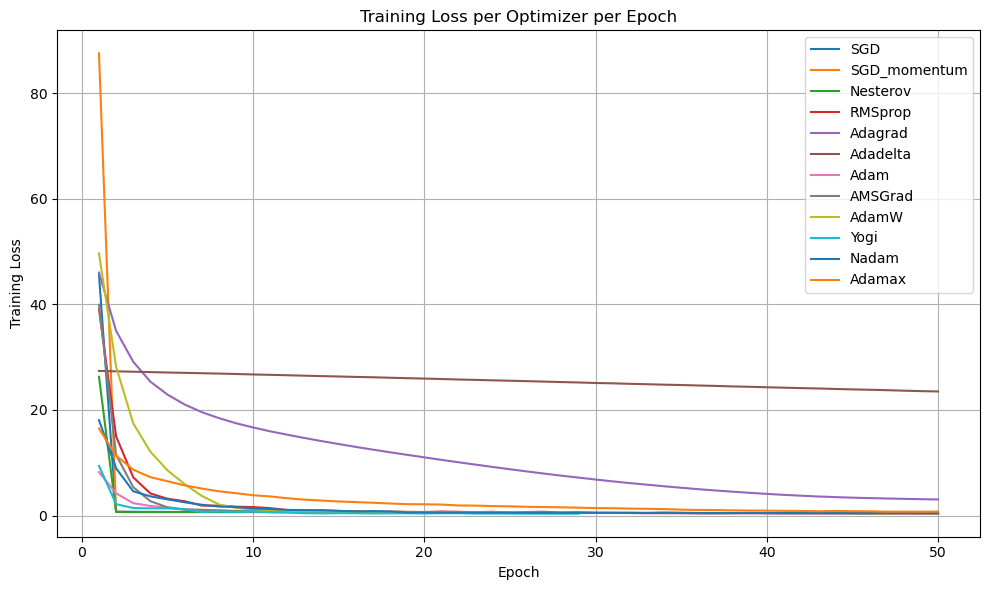

In [76]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot Training Loss per Optimizer per Epoch
plt.figure(figsize=(10, 6))

# Loop through results to access each optimizer's training history
for optimizer_name, result in results.items():
    # Retrieve the training loss history for this optimizer
    if 'loss' in result['history'].history:
        loss_history = result['history'].history['loss']
    else:
        # In case the loss key isn't found (unexpected behavior), use a default empty list
        loss_history = []

    # Plot the training loss history
    plt.plot(range(1, len(loss_history) + 1), loss_history, label=optimizer_name)

# Set plot labels and titles
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Optimizer per Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [74]:
final_df.to_csv('Titanic_nn_r(3).csv', index=False)

In [73]:
# import numpy as np

# # Count the number of categorical and float features
# num_categorical_features = (Xc.dtypes == 'object').sum()
# num_float_features = (Xc.dtypes == 'float64').sum()

# # Initialize variables for total number of neurons and total number of dense layers
# total_neurons = 0
# num_dense_layers = 0

# # Calculate the total number of neurons in dense layers and the total number of dense layers
# for layer in neural_network_model.model.layers:
#     if isinstance(layer, tf.keras.layers.Dense):
#         total_neurons += layer.output_shape[1]
#         num_dense_layers += 1

# # Calculate the mean number of neurons
# mean_num_neurons = total_neurons / num_dense_layers


# # Extract relevant information from the data
# data_info = {
#     'Data Name': ["Titanic dataset"] * len(optimizers),
#     'Data Size': [X_train.shape[0]] * len(optimizers),
#     'Number of Features': [X_train.shape[1]] * len(optimizers),
#     'Number of Categorical Features': [num_categorical_features] * len(optimizers),
#     'Number of Float Features': [num_float_features] * len(optimizers),
#     'Target Feature Type': [yc.dtype] * len(optimizers),
#     'Neural Network Architecture': ["Feedforward Neural Network (FNN)"] * len(optimizers),
#     'Number of Layers': [num_dense_layers] * len(optimizers),
#     'Minimal Number of Epochs': [min(results[name]['convergence_speed'] for name in results)] * len(optimizers),
#     'Mean Number of Neurons': [mean_num_neurons] * len(optimizers),
#     'Optimization Method': list(optimizers.keys())
# }

# # Calculate the number of neurons in each dense layer
# num_neurons_per_layer = [layer.output_shape[1] for layer in neural_network_model.model.layers if isinstance(layer, tf.keras.layers.Dense)]

# # Add number of neurons in each dense layer to the data_info dictionary
# for i in range(num_dense_layers):
#     data_info[f'Number of Neurons in Layer {i+1}'] = [num_neurons_per_layer[i]] * len(optimizers)
    
# # Extract results for each optimization method
# results_info = {
#     'Optimization Method': [],
#     'Test Accuracy': [],
#     'Precision': [],
#     'Recall': [],
#     'F1-score': [],
#     'Convergence Speed': [],
#     'Training Time': [],
#     'Training Loss': [],
#     'Validation Loss': []
# }

# for optimizer, result in results.items():
#     results_info['Optimization Method'].append(optimizer)
#     results_info['Test Accuracy'].append(result['test_accuracy'])
#     results_info['Precision'].append(result['precision'])
#     results_info['Recall'].append(result['recall'])
#     results_info['F1-score'].append(result['f1_score'])
#     results_info['Convergence Speed'].append(result['convergence_speed'])
#     results_info['Training Time'].append(result['training_time'])
#     results_info['Training Loss'].append(result['history'].history['loss'][0])
#     results_info['Validation Loss'].append(result['history'].history['val_loss'][0])

# # Create DataFrame
# data_df = pd.DataFrame(data_info)
# results_df = pd.DataFrame(results_info)

# # Merge DataFrames
# final_df = pd.merge(data_df, results_df, on='Optimization Method')

# # print(final_df)

# final_df.head(9)

################################ Before Presentation ######################################################

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout

class TitanicDatasetPreprocessor:
    def __init__(self, train_path, test_path):
        self.train_path = train_path
        self.test_path = test_path
        self.traindf = None
        self.testdf = None
        self.target = None
        self.train = None
        self.test = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def load_data(self):
        self.traindf = pd.read_csv(self.train_path)
        self.testdf = pd.read_csv(self.test_path)

    def preprocess_data(self):
        # Concatenate train and test dataframes
        df = pd.concat([self.traindf, self.testdf], axis=0, sort=False)

        # Extract Title from Name
        df['Title'] = df.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
        df['Title'] = df['Title'].replace(['Ms', 'Mlle'], 'Miss')
        df['Title'] = df['Title'].replace('Mme', 'Mrs')

        # Extract LastName
        df['LastName'] = df.Name.str.split(',').str[0]

        # Identify women and boys
        df['IsWomanOrBoy'] = ((df['Title'] == 'Master') | (df['Sex'] == 'female'))

        # Count women and boys in the family
        df['WomanOrBoyCount'] = df.groupby('LastName')['IsWomanOrBoy'].transform('sum')
        # Subtract one from WomanOrBoyCount if individual is a woman or boy
        df['WomanOrBoyCount'] = df['WomanOrBoyCount'] - df['IsWomanOrBoy']

        # Count survived women and boys in the family
        df['FamilySurvivedCount'] = df.groupby('LastName')['Survived'].transform('sum')

        # Subtract survived count for current individual if woman or boy
        df['FamilySurvivedCount'] = df['FamilySurvivedCount'] - df['IsWomanOrBoy'] * df['Survived'].fillna(0)

        # Calculate survival rate of women and boys in the family
        df['WomanOrBoySurvived'] = df['FamilySurvivedCount'] / df['WomanOrBoyCount'].replace(0, np.nan)

        # Handle missing values
        df['WomanOrBoyCount'] = df['WomanOrBoyCount'].fillna(0)
        df['WomanOrBoySurvived'] = df['WomanOrBoySurvived'].fillna(0)

        # Impute missing values
        df['Embarked'] = df['Embarked'].fillna('S')
        df['Deck'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
        df.loc[df['Deck'] == 'T', 'Deck'] = 'A'
        med_fare = df.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
        df['Fare'] = df['Fare'].fillna(med_fare)

        # Reset index again
        df.reset_index(drop=True, inplace=True)

        # Calculate median age by group
        age_group_medians = df.groupby(['Sex', 'Pclass', 'Title'])['Age'].median()

        # Fill missing values using median age by group
        df['Age'] = df.apply(
            lambda row: age_group_medians[row['Sex'], row['Pclass'], row['Title']] if np.isnan(row['Age']) else row['Age'],
            axis=1
        )

        # Calculate Family_Size
        df['Family_Size'] = df['SibSp'] + df['Parch'] + 1

        # Drop unnecessary columns
        cols_to_drop = ['Name', 'Ticket', 'Cabin']
        df = df.drop(cols_to_drop, axis=1)

        # Fill missing values
        df['Alone'] = (df['WomanOrBoyCount'] == 0).astype(int)

        # Fill remaining missing values
        df['WomanOrBoySurvived'] = df['WomanOrBoySurvived'].fillna(0)
        df['WomanOrBoyCount'] = df['WomanOrBoyCount'].fillna(0)
        df['FamilySurvivedCount'] = df['FamilySurvivedCount'].fillna(0)
        df['Alone'] = df['Alone'].fillna(0)

        self.target = df.Survived.loc[self.traindf.index]
        df = df.drop(['Survived'], axis=1)
        self.train, self.test = df.loc[self.traindf.index], df.loc[self.testdf.index]

    def encode_categorical_features(self):
        numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        categorical_columns = []
        features = self.train.columns.values.tolist()
        for col in features:
            if self.train[col].dtype in numerics:
                continue
            categorical_columns.append(col)

        for col in categorical_columns:
            if col in self.train.columns:
                le = LabelEncoder()
                le.fit(list(self.train[col].astype(str).values) + list(self.test[col].astype(str).values))
                self.train[col] = le.transform(list(self.train[col].astype(str).values))
                self.test[col] = le.transform(list(self.test[col].astype(str).values))

    def split_train_test(self, test_size=0.3, random_state=100):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.train, self.target,
                                                                            test_size=test_size,
                                                                            random_state=random_state)


In [2]:
class NeuralNetworkModel:
    def __init__(self):
        self.model = None
    
    def build_ann(self, input_shape, optimizer='adam'):
        self.model = Sequential()
        self.model.add(Dense(units=32, kernel_initializer='glorot_uniform', activation='relu', input_shape=(input_shape,)))
        self.model.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
        self.model.add(Dropout(rate=0.5))
        self.model.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
        self.model.add(Dropout(rate=0.5))
        self.model.add(Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))
        self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    def train(self, X_train, y_train, epochs=100, batch_size=32, validation_data=None):
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data)
        return history
    
    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test)

In [3]:
# Example usage
preprocessor = TitanicDatasetPreprocessor('Titanic-data/train (1).csv', 'Titanic-data/test.csv')  
preprocessor.load_data()
preprocessor.preprocess_data()
preprocessor.encode_categorical_features()
preprocessor.split_train_test()

Training model with SGD optimizer...
Epoch 1/2
20/20 [==============================] - 2s 30ms/step - loss: 8.9625 - accuracy: 0.5570 - val_loss: 0.6820 - val_accuracy: 0.6082
Epoch 2/2
9/9 [==============================] - 0s 3ms/step - loss: 0.6913 - accuracy: 0.5560
Training model with Adam optimizer...
Epoch 1/2
20/20 [==============================] - 1s 23ms/step - loss: 22.3964 - accuracy: 0.5506 - val_loss: 9.5117 - val_accuracy: 0.5933
Epoch 2/2
9/9 [==============================] - 0s 3ms/step - loss: 1.8538 - accuracy: 0.6343
Training model with RMSprop optimizer...
Epoch 1/2
20/20 [==============================] - 1s 17ms/step - loss: 23.8346 - accuracy: 0.5297 - val_loss: 5.8306 - val_accuracy: 0.5933
Epoch 2/2
9/9 [==============================] - 0s 4ms/step - loss: 4.4109 - accuracy: 0.5896
Training model with Adagrad optimizer...
Epoch 1/2
20/20 [==============================] - 1s 18ms/step - loss: 23.2247 - accuracy: 0.4976 - val_loss: 4.3670 - val_accuracy: 0.

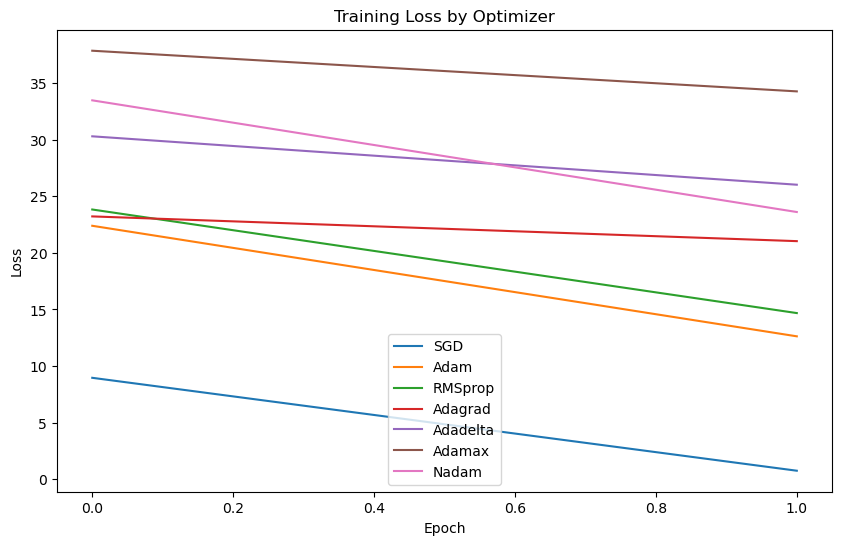

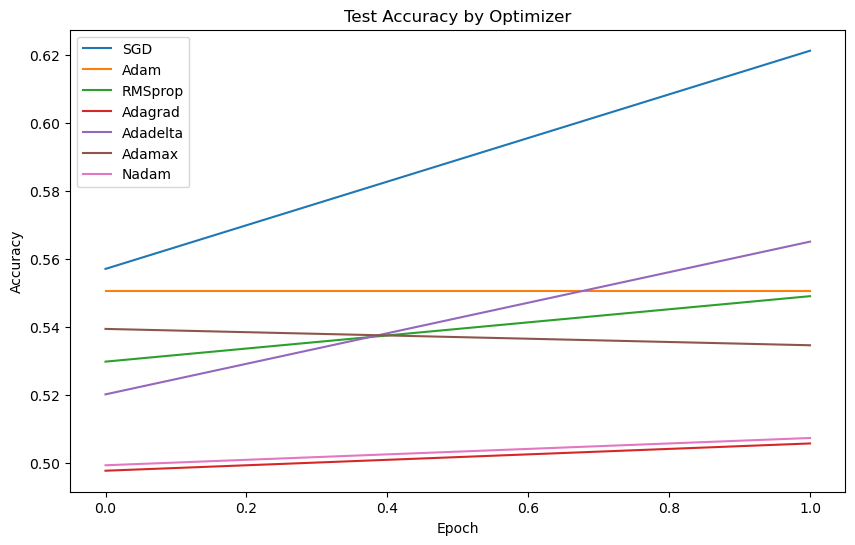

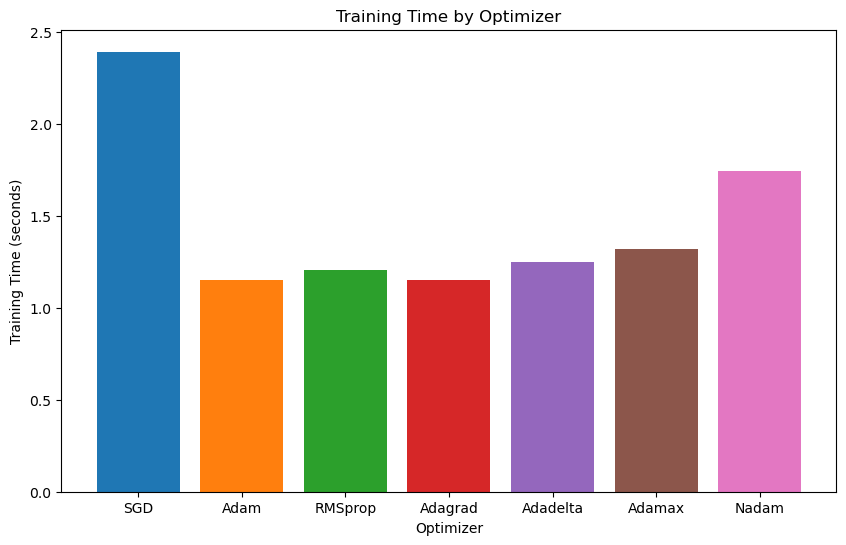

In [4]:
import time
import matplotlib.pyplot as plt

# List of optimizers to test for NN
optimizers = {
    'SGD': 'SGD',
    'Adam': 'adam',
    'RMSprop': 'RMSprop',
    'Adagrad': 'Adagrad',
    'Adadelta': 'Adadelta',
    'Adamax': 'Adamax',
    'Nadam': 'Nadam'
}

results = {}

for name, optimizer_name in optimizers.items():
    print(f"Training model with {name} optimizer...")
    # preprocessor = TitanicDatasetPreprocessor('Titanic-data/train.csv', 'Titanic-data/test.csv')
    # preprocessor.load_data()
    # preprocessor.preprocess_data()
    # preprocessor.encode_categorical_features()
    # preprocessor.split_train_test()
    
    model_instance = NeuralNetworkModel()
    model_instance.build_ann(preprocessor.X_train.shape[1], optimizer=optimizer_name)
    start_time = time.time()
    history = model_instance.train(preprocessor.X_train, preprocessor.y_train, epochs=2, batch_size=32, validation_data=(preprocessor.X_test, preprocessor.y_test))
    end_time = time.time()
    test_loss, test_acc = model_instance.evaluate(preprocessor.X_test, preprocessor.y_test)
    training_time = end_time - start_time
    results[name] = {'test_accuracy': test_acc, 'convergence_speed': len(history.history['loss']), 'training_time': training_time, 'history': history}

# Print results
print("\nResults:")
for name, result in results.items():
    print(f"{name}: Test Accuracy - {result['test_accuracy']:.4f}, "
          f"Convergence Speed - {result['convergence_speed']} epochs, "
          f"Training Time - {result['training_time']:.2f} seconds")

# Plot training history
plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['history'].history['loss'], label=name)
plt.title('Training Loss by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['history'].history['accuracy'], label=name)
plt.title('Test Accuracy by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.bar(name, result['training_time'])
plt.title('Training Time by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Training Time (seconds)')
plt.show()

In [5]:
# Step 1: Collect results and metrics
optimizer_metrics = {}  # Dictionary to store optimizer metrics

for optimizer, result in results.items():
    accuracy = result['test_accuracy']
    loss = result['history'].history['loss'][-1]
    training_time = result['training_time']
    optimizer_metrics[optimizer] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# Step 2: Analyze metrics
best_optimizer = None
best_accuracy = 0
lowest_loss = float('inf')
shortest_training_time = float('inf')

for optimizer, metrics in optimizer_metrics.items():
    accuracy = metrics['accuracy']
    loss = metrics['loss']
    training_time = metrics['training_time']
    
    # Determine the best optimizer based on accuracy, loss, and training time
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        lowest_loss = loss
        shortest_training_time = training_time
        best_optimizer = optimizer
    elif accuracy == best_accuracy and loss < lowest_loss:
        lowest_loss = loss
        shortest_training_time = training_time
        best_optimizer = optimizer
    elif accuracy == best_accuracy and loss == lowest_loss and training_time < shortest_training_time:
        shortest_training_time = training_time
        best_optimizer = optimizer

# Step 3: Print or return the best performing optimizer
print(f"Best performing optimizer: {best_optimizer}")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"Loss: {lowest_loss:.4f}")
print(f"Shortest Training Time: {shortest_training_time:.2f} seconds")

Best performing optimizer: Adam
Accuracy: 0.6343
Loss: 12.6282
Shortest Training Time: 1.15 seconds


Comparison of Optimizers:
          accuracy       loss  training_time
SGD       0.555970   0.752216       2.390736
Adam      0.634328  12.628212       1.149944
RMSprop   0.589552  14.682498       1.203116
Adagrad   0.593284  21.038486       1.148110
Adadelta  0.593284  26.024691       1.250252
Adamax    0.608209  34.272732       1.316298
Nadam     0.589552  23.612362       1.743126


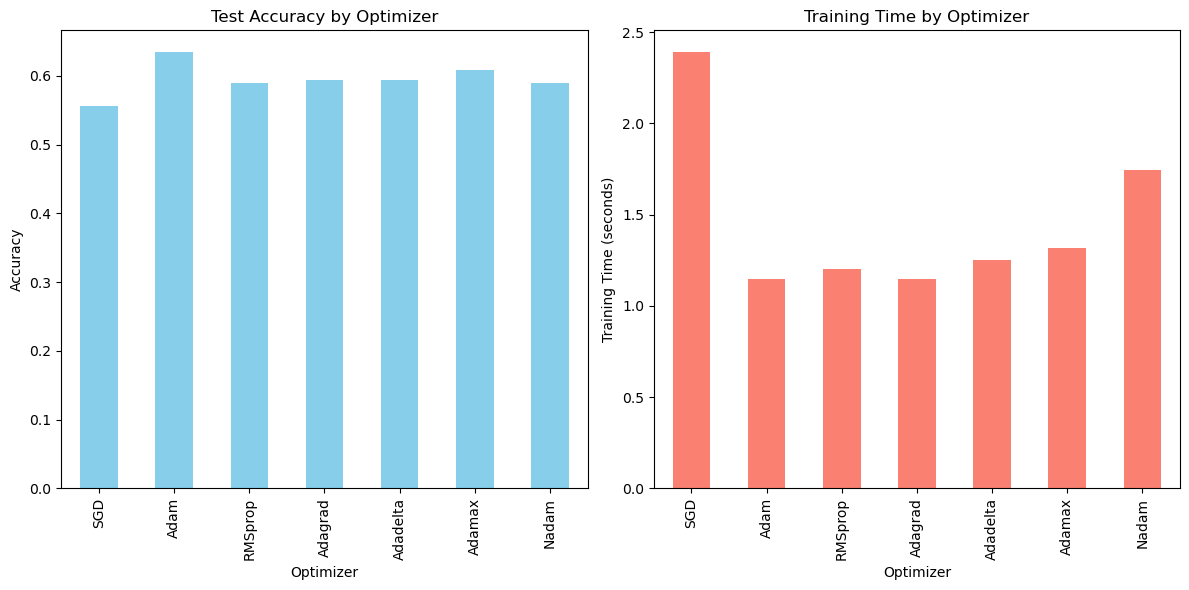

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Collect results and metrics
optimizer_metrics = {}  # Dictionary to store optimizer metrics

for optimizer, result in results.items():
    accuracy = result['test_accuracy']
    loss = result['history'].history['loss'][-1]
    training_time = result['training_time']
    optimizer_metrics[optimizer] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# Step 2: Create a dataframe for comparison
df = pd.DataFrame(optimizer_metrics).T  # Transpose to have optimizers as rows

# Step 3: Plot the comparison using a table
print("Comparison of Optimizers:")
print(df)

# Step 4: Plot the comparison using a graph
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df['accuracy'].plot(kind='bar', color='skyblue')
plt.title('Test Accuracy by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
df['training_time'].plot(kind='bar', color='salmon')
plt.title('Training Time by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Training Time (seconds)')

plt.tight_layout()
plt.show()


In [1]:
pip install tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adamax, Nadam
#import keras_adabound  # For AdaBound
import tensorflow_addons as tfa  # For AdamW, Yogi, and Lookahead
import tensorflow as tf

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\werka\miniconda3\envs\py310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If 

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout

class TitanicDatasetPreprocessor:
    def __init__(self, train_path, test_path):
        self.train_path = train_path
        self.test_path = test_path
        self.traindf = None
        self.testdf = None
        self.target = None
        self.train = None
        self.test = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def load_data(self):
        self.traindf = pd.read_csv(self.train_path)
        self.testdf = pd.read_csv(self.test_path)

    def preprocess_data(self):
        # Concatenate train and test dataframes
        df = pd.concat([self.traindf, self.testdf], axis=0, sort=False)

        # Extract Title from Name
        df['Title'] = df.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
        df['Title'] = df['Title'].replace(['Ms', 'Mlle'], 'Miss')
        df['Title'] = df['Title'].replace('Mme', 'Mrs')

        # Extract LastName
        df['LastName'] = df.Name.str.split(',').str[0]

        # Identify women and boys
        df['IsWomanOrBoy'] = ((df['Title'] == 'Master') | (df['Sex'] == 'female'))

        # Count women and boys in the family
        df['WomanOrBoyCount'] = df.groupby('LastName')['IsWomanOrBoy'].transform('sum')
        # Subtract one from WomanOrBoyCount if individual is a woman or boy
        df['WomanOrBoyCount'] = df['WomanOrBoyCount'] - df['IsWomanOrBoy']

        # Count survived women and boys in the family
        df['FamilySurvivedCount'] = df.groupby('LastName')['Survived'].transform('sum')

        # Subtract survived count for current individual if woman or boy
        df['FamilySurvivedCount'] = df['FamilySurvivedCount'] - df['IsWomanOrBoy'] * df['Survived'].fillna(0)

        # Calculate survival rate of women and boys in the family
        df['WomanOrBoySurvived'] = df['FamilySurvivedCount'] / df['WomanOrBoyCount'].replace(0, np.nan)

        # Handle missing values
        df['WomanOrBoyCount'] = df['WomanOrBoyCount'].fillna(0)
        df['WomanOrBoySurvived'] = df['WomanOrBoySurvived'].fillna(0)

        # Impute missing values
        df['Embarked'] = df['Embarked'].fillna('S')
        df['Deck'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
        df.loc[df['Deck'] == 'T', 'Deck'] = 'A'
        med_fare = df.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
        df['Fare'] = df['Fare'].fillna(med_fare)

        # Reset index again
        df.reset_index(drop=True, inplace=True)

        # Calculate median age by group
        age_group_medians = df.groupby(['Sex', 'Pclass', 'Title'])['Age'].median()

        # Fill missing values using median age by group
        df['Age'] = df.apply(
            lambda row: age_group_medians[row['Sex'], row['Pclass'], row['Title']] if np.isnan(row['Age']) else row['Age'],
            axis=1
        )

        # Calculate Family_Size
        df['Family_Size'] = df['SibSp'] + df['Parch'] + 1

        # Drop unnecessary columns
        cols_to_drop = ['Name', 'Ticket', 'Cabin']
        df = df.drop(cols_to_drop, axis=1)

        # Fill missing values
        df['Alone'] = (df['WomanOrBoyCount'] == 0).astype(int)

        # Fill remaining missing values
        df['WomanOrBoySurvived'] = df['WomanOrBoySurvived'].fillna(0)
        df['WomanOrBoyCount'] = df['WomanOrBoyCount'].fillna(0)
        df['FamilySurvivedCount'] = df['FamilySurvivedCount'].fillna(0)
        df['Alone'] = df['Alone'].fillna(0)

        self.target = df.Survived.loc[self.traindf.index]
        df = df.drop(['Survived'], axis=1)
        self.train, self.test = df.loc[self.traindf.index], df.loc[self.testdf.index]

    def encode_categorical_features(self):
        numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        categorical_columns = []
        features = self.train.columns.values.tolist()
        for col in features:
            if self.train[col].dtype in numerics:
                continue
            categorical_columns.append(col)

        for col in categorical_columns:
            if col in self.train.columns:
                le = LabelEncoder()
                le.fit(list(self.train[col].astype(str).values) + list(self.test[col].astype(str).values))
                self.train[col] = le.transform(list(self.train[col].astype(str).values))
                self.test[col] = le.transform(list(self.test[col].astype(str).values))

    def split_train_test(self, test_size=0.3, random_state=100):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.train, self.target,
                                                                            test_size=test_size,
                                                                            random_state=random_state)


In [4]:
class NeuralNetworkModel:
    def __init__(self):
        self.model = None
    
    def build_ann(self, input_shape, optimizer='adam'):
        self.model = Sequential()
        self.model.add(Dense(units=32, kernel_initializer='glorot_uniform', activation='relu', input_shape=(input_shape,)))
        self.model.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
        self.model.add(Dropout(rate=0.5))
        self.model.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
        self.model.add(Dropout(rate=0.5))
        self.model.add(Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))
        self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    def train(self, X_train, y_train, epochs=100, batch_size=32, validation_data=None):
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data)
        return history
    
    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test)

In [5]:
# Example usage with additional optimizers
preprocessor = TitanicDatasetPreprocessor('Titanic-data/train (1).csv', 'Titanic-data/test.csv')  
preprocessor.load_data()
preprocessor.preprocess_data()
preprocessor.encode_categorical_features()
preprocessor.split_train_test()

Training model with SGD optimizer...
Epoch 1/100
20/20 [==============================] - 2s 20ms/step - loss: 10.0337 - accuracy: 0.5827 - val_loss: 0.6925 - val_accuracy: 0.5970
Epoch 2/100
20/20 [==============================] - 0s 11ms/step - loss: 0.7030 - accuracy: 0.6260 - val_loss: 0.6882 - val_accuracy: 0.6007
Epoch 3/100
20/20 [==============================] - 0s 7ms/step - loss: 0.7014 - accuracy: 0.6228 - val_loss: 0.6865 - val_accuracy: 0.5896
Epoch 4/100
20/20 [==============================] - 0s 7ms/step - loss: 0.6840 - accuracy: 0.6228 - val_loss: 0.6840 - val_accuracy: 0.5933
Epoch 5/100
20/20 [==============================] - 0s 8ms/step - loss: 0.6870 - accuracy: 0.6244 - val_loss: 0.6822 - val_accuracy: 0.5933
Epoch 6/100
20/20 [==============================] - 0s 8ms/step - loss: 0.6829 - accuracy: 0.6260 - val_loss: 0.6803 - val_accuracy: 0.5933
Epoch 7/100
20/20 [==============================] - 0s 9ms/step - loss: 0.6827 - accuracy: 0.6244 - val_loss: 0.6

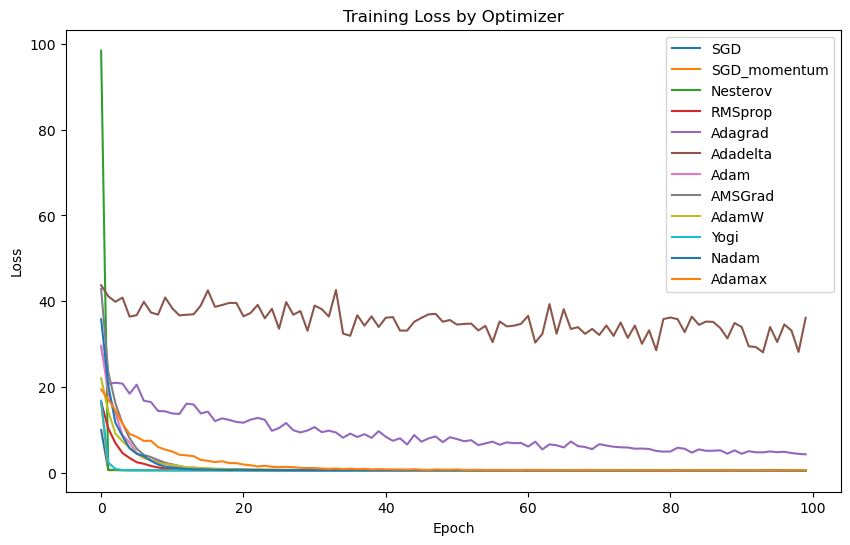

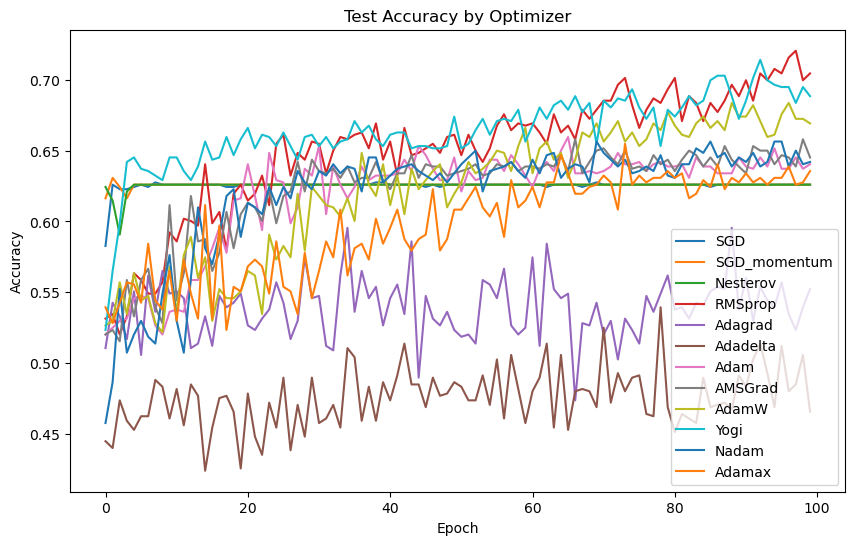

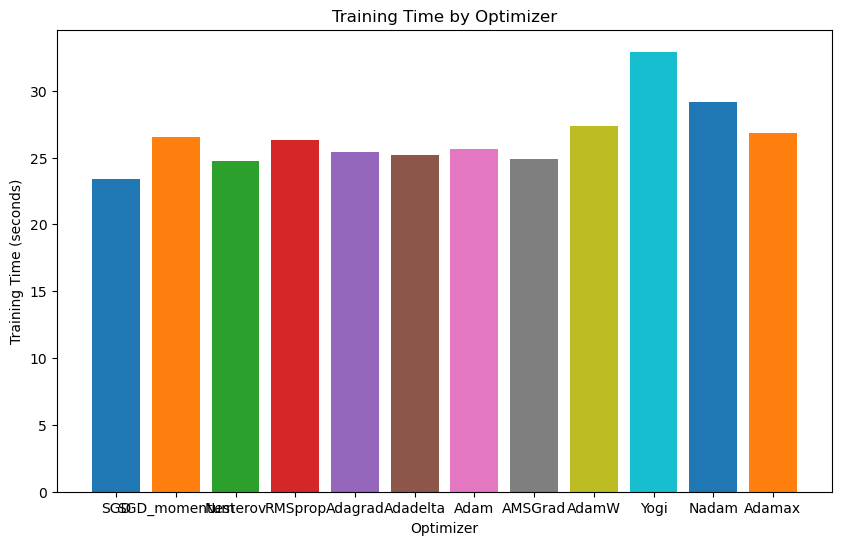

In [6]:
import time
import matplotlib.pyplot as plt

# List of optimizers to test for NN
optimizers = {
    'SGD': tf.keras.optimizers.SGD(),
    'SGD_momentum': tf.keras.optimizers.SGD(momentum=0.9),
    'Nesterov': tf.keras.optimizers.SGD(momentum=0.9, nesterov=True),
    'RMSprop': tf.keras.optimizers.RMSprop(),
    'Adagrad': tf.keras.optimizers.Adagrad(),
    'Adadelta': tf.keras.optimizers.Adadelta(),
    'Adam': tf.keras.optimizers.Adam(),
    'AMSGrad': tf.keras.optimizers.Adam(amsgrad=True),
    'AdamW': tfa.optimizers.AdamW(weight_decay=1e-4),
    'Yogi': tfa.optimizers.Yogi(),
    'Nadam': tf.keras.optimizers.Nadam(),
    'Adamax': tf.keras.optimizers.Adamax()
}

results = {}
for name, optimizer in optimizers.items():
    print(f"Training model with {name} optimizer...")
    model_instance = NeuralNetworkModel()
    model_instance.build_ann(preprocessor.X_train.shape[1], optimizer=optimizer)
    start_time = time.time()
    history = model_instance.train(preprocessor.X_train, preprocessor.y_train, epochs=100, batch_size=32, validation_data=(preprocessor.X_test, preprocessor.y_test))
    end_time = time.time()
    test_loss, test_acc = model_instance.evaluate(preprocessor.X_test, preprocessor.y_test)
    training_time = end_time - start_time
    results[name] = {'test_accuracy': test_acc, 'convergence_speed': len(history.history['loss']), 'training_time': training_time, 'history': history}

# Print results
print("\nResults:")
for name, result in results.items():
    print(f"{name}: Test Accuracy - {result['test_accuracy']:.4f}, "
          f"Convergence Speed - {result['convergence_speed']} epochs, "
          f"Training Time - {result['training_time']:.2f} seconds")

# Plot training history
plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['history'].history['loss'], label=name)
plt.title('Training Loss by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['history'].history['accuracy'], label=name)
plt.title('Test Accuracy by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.bar(name, result['training_time'])
plt.title('Training Time by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Training Time (seconds)')
plt.show()


In [9]:
# Assumption: The 'results' dictionary has been filled with training data as in your original code.

# Step 1: Collect results and metrics
optimizer_metrics = {}  # Dictionary to store optimizer metrics

for name, result in results.items():
    accuracy = result['test_accuracy']
    loss = result['history'].history['loss'][-1]  # Get the last loss value
    training_time = result['training_time']
    optimizer_metrics[name] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# Step 2: Analyze metrics
best_optimizer = None
best_accuracy = 0
lowest_loss = float('inf')
shortest_training_time = float('inf')

for name, metrics in optimizer_metrics.items():
    accuracy = metrics['accuracy']
    loss = metrics['loss']
    training_time = metrics['training_time']
    
    # Determine the best optimizer based on accuracy, loss, and training time
    if accuracy > best_accuracy or (accuracy == best_accuracy and loss < lowest_loss):
        best_accuracy = accuracy
        lowest_loss = loss
        shortest_training_time = training_time
        best_optimizer = name
    elif accuracy == best_accuracy and loss == lowest_loss and training_time < shortest_training_time:
        shortest_training_time = training_time
        best_optimizer = name

# Step 3: Print or return the best performing optimizer
print(f"Best performing optimizer: {best_optimizer}")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"Loss: {lowest_loss:.4f}")
print(f"Shortest Training Time: {shortest_training_time:.2f} seconds")


Best performing optimizer: RMSprop
Accuracy: 0.7201
Loss: 0.5541
Shortest Training Time: 26.29 seconds


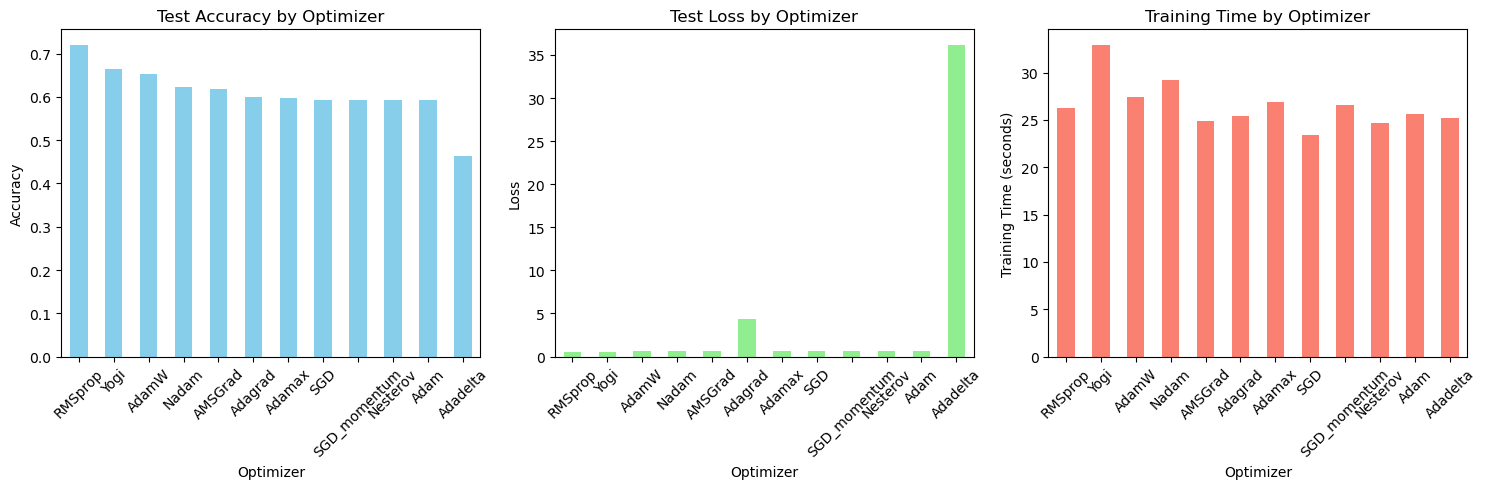

Comparison of Optimizers:
              accuracy       loss  training_time
RMSprop       0.720149   0.554099      26.292910
Yogi          0.664179   0.586140      32.914194
AdamW         0.652985   0.613196      27.384638
Nadam         0.623134   0.639886      29.175075
AMSGrad       0.619403   0.638878      24.913321
Adagrad       0.600746   4.356136      25.393466
Adamax        0.597015   0.678555      26.847498
SGD           0.593284   0.660222      23.415042
SGD_momentum  0.593284   0.661383      26.517786
Nesterov      0.593284   0.661225      24.708064
Adam          0.593284   0.613091      25.613522
Adadelta      0.462687  36.168640      25.222317


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the 'results' dictionary is populated with the training results from the earlier code

# Step 1: Collect results and metrics
optimizer_metrics = {}  # Dictionary to store optimizer metrics

for name, result in results.items():
    accuracy = result['test_accuracy']
    loss_history = result['history'].history['loss']
    if len(loss_history) > 0:  # Ensure there is at least one loss value
        loss = loss_history[-1]  # Get the last loss value
    else:
        loss = None
    training_time = result['training_time']
    optimizer_metrics[name] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# Step 2: Create a dataframe for comparison
df = pd.DataFrame(optimizer_metrics).T  # Transpose to have optimizers as rows
df.sort_values('accuracy', ascending=False, inplace=True)  # Sort by accuracy in descending order

# Step 3: Plot the comparison using a graph
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df['accuracy'].plot(kind='bar', color='skyblue')
plt.title('Test Accuracy by Optimizer')
plt.xlabel('Optimizer')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')

plt.subplot(1, 3, 2)
df['loss'].plot(kind='bar', color='lightgreen')
plt.title('Test Loss by Optimizer')
plt.xlabel('Optimizer')
plt.xticks(rotation=45)
plt.ylabel('Loss')

plt.subplot(1, 3, 3)
df['training_time'].plot(kind='bar', color='salmon')
plt.title('Training Time by Optimizer')
plt.xlabel('Optimizer')
plt.xticks(rotation=45)
plt.ylabel('Training Time (seconds)')

plt.tight_layout()
plt.show()

# Step 4: Optionally, print the DataFrame for a text-based comparison
print("Comparison of Optimizers:")
print(df)